### Importing libraries


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations
import numpy as np
import pickle
from numpy import mean
from numpy import std
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import RepeatedKFold, KFold, train_test_split 
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, classification_report, roc_auc_score, confusion_matrix, auc, roc_curve, precision_recall_curve
from sklearn.utils import compute_sample_weight, resample, shuffle
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import random
import copy
import time
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Preparing the data

In [5]:
with open('/content/drive/My Drive/Queen Mary University/3rd year/Final Year Project/pre3_2-sec_0.5_EEG_data.pickle', 'rb') as f:
  X = pickle.load(f) #Signals
  y = pickle.load(f) #annotations

In [6]:
#Normalize data
X = stats.zscore(X, axis=None)

In [7]:
#Data shapes
print('Shape of signal data: ',X.shape)
print(X[0:3])
print('Shape of label data: ',y.shape)
print(y[0:3])

Shape of signal data:  (563163, 512)
[[ 0.21940254  0.11464756  0.1150003  ... -0.27896224 -0.18255697
  -0.09999134]
 [-0.14565016 -0.1302213  -0.17525955 ... -0.28014189 -0.18335632
  -0.06391921]
 [-0.21955583 -0.33878428 -0.24957115 ... -0.03983156 -0.11408696
  -0.07703492]]
Shape of label data:  (563163, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


### Auxiliary functions

#### Class count function

In [8]:
def getCount(y_dataset):
  o_count = sum((y_dataset == (1., 0., 0.)).all(axis=1))
  ss_count = sum((y_dataset == (0., 1., 0.)).all(axis=1))
  kc_count = sum((y_dataset == (0., 0., 1.)).all(axis=1))
  both_count = sum((y_dataset == (0., 1., 1.)).all(axis=1))
  no_class = sum((y_dataset == (0., 0., 0.)).all(axis=1))
  other_and_ss = sum((y_dataset == (1., 1., 0.)).all(axis=1))
  other_and_kc = sum((y_dataset == (1., 0., 1.)).all(axis=1))
  all_classes = sum((y_dataset == (1., 1., 1.)).all(axis=1))

  print('Other count: ', o_count)
  print('SS count: ', ss_count)
  print('KC count: ', kc_count)
  print('Both count: ', both_count)
  print('No classes: ', no_class)
  print('Other and SS: ', other_and_ss)
  print('Other and KC: ', other_and_kc)
  print('All classes: ', all_classes)

#### Resampler function

In [9]:
def resampler(X, y, us_percent, ds_percent):

  #Extracting minority classes
  idx_ss = np.where((y == (0., 1., 0.)).all(axis=1))[0]
  idx_kc = np.where((y == (0., 0., 1.)).all(axis=1))[0]
  idx_both = np.where((y == (0., 1., 1.)).all(axis=1))[0]

  ss_X, ss_y = X[idx_ss], y[idx_ss]
  kc_X, kc_y = X[idx_kc], y[idx_kc]
  both_X, both_y = X[idx_both], y[idx_both]

  #Upsampling minority classes
  nr_samples_ss = int(us_percent*ss_X.shape[0])
  nr_samples_kc = int(us_percent*kc_X.shape[0])
  nr_samples_both = int(us_percent*both_X.shape[0])

  us_ss_X, us_ss_y  = resample(ss_X, ss_y, replace=True, n_samples=nr_samples_ss, random_state=2021)
  us_kc_X, us_kc_y = resample(kc_X, kc_y, replace=True, n_samples=nr_samples_kc, random_state=2021)
  us_both_X, us_both_y = resample(both_X, both_y, replace=True, n_samples=nr_samples_both, random_state=2021)

  #Extracting majority class
  idx_majClass = np.where((y == (1., 0., 0.)).all(axis=1))[0]
  majClass_X = X[idx_majClass]
  majClass_y = y[idx_majClass]


  #Downsample majority class
  nr_samples_maj = int(ds_percent*(nr_samples_ss+nr_samples_kc+nr_samples_both))
  ds_X, ds_y = resample(majClass_X, majClass_y, replace=False, n_samples=nr_samples_maj, random_state=2021)

  #Concatenating back again
  args_X = (us_ss_X, ds_X, us_kc_X, us_both_X)
  args_y = (us_ss_y, ds_y, us_kc_y, us_both_y)

  X = np.concatenate(args_X, axis=0)
  y = np.concatenate(args_y, axis=0)

  #Shuffle for random order, but with a state so signals still correspond to their labels. 
  #This will also prevent the "validation_split"-parameter in the Keras fit function from choosing a homogenous validation set (it chooses the last x percent by default)
  
  seed = random.randint(0,3000)
  # rand_state = 2021
  X, y = shuffle(X, y, random_state=seed)
  
  return X, y, nr_samples_maj, nr_samples_ss, nr_samples_kc, nr_samples_both


#### Class threshold functions

##### Threshold rounder function

In [10]:
def th_rounder(y_pred, ths):

  for i in range(len(ths)): #The "other" th needs to be sent as param [0] in ths
    above_idx = np.where(y_pred[:,i+1] >= ths[i])[0]
    below_idx = np.where(y_pred[:,i+1] < ths[i])[0]
    y_pred[above_idx,i+1] = 1.0
    y_pred[below_idx,i+1] = 0.0
  
  above_idx_oth = np.where((y_pred[:,1] == 0.0) & (y_pred[:,2] == 0.0))[0]
  y_pred[above_idx_oth,0] = 1.0
  below_idx_oth = np.where(y_pred[:,0] != 1.0)[0]
  y_pred[below_idx_oth,0] = 0.0

  return y_pred

##### Threshold vs (count/f1/precision/recall) plots

In [11]:
def printThresholdPlot(c_pred, c_act, f1_score, pre_score, re_score, ths, classType):

  print(classType)
  plt.style.use('seaborn-dark')
  fig,ax = plt.subplots(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='pink')
  ax.set_title('Rounding threshold vs segment count/performance scores', fontsize=20)
  ax.set_xlabel("Thresholds",fontsize=15)
  ax.set_ylabel("Segment Count",fontsize=15)
  p1, = ax.plot(ths, c_pred, color="navy", label='Predicted count')
  p2, = ax.plot(ths, c_act , color="orange", label='True count')

  ax2=ax.twinx()
  p3, = ax2.plot(ths, f1_score, color="maroon", label='F1-Score')
  p4, = ax2.plot(ths, pre_score, color="green", label='Precision')
  p5, = ax2.plot(ths, re_score, color="violet", label='Recall')
  ax2.set_ylabel("F1-score, Precision, Recall",fontsize=14)

  legend = ax.legend(handles=[p1, p2, p3, p4, p5], bbox_to_anchor=(1.0, 1.0), loc='best', fontsize='large', frameon=True)
  legend.get_frame().set_linewidth(2.0)
  legend.get_frame().set_edgecolor("black")
  plt.show()

  print('\n' + classType + ' true count ----------> ',c_act[0])

#### Confusion Matrix functions

In [12]:
# Converting labelled data to single-label, so it can fit within the sklearn "confusion_matrix" function
def getSingleLabel(y_dataset):

  o_bool = (y_dataset == (1., 0., 0.)).all(axis=1)
  ss_bool = (y_dataset == (0., 1., 0.)).all(axis=1)
  kc_bool = (y_dataset == (0., 0., 1.)).all(axis=1)
  both_bool = (y_dataset == (0., 1., 1.)).all(axis=1)

  y_dataset[o_bool] = 0
  y_dataset[ss_bool] = 1
  y_dataset[kc_bool] = 2
  y_dataset[both_bool] = 3

  singleLabel_y = np.amax(y_dataset, axis=1)
  return singleLabel_y

In [13]:
# Printing a heatmap-version of the CNN confusion matrix
def printConfusionMatrix(y_true, y_pred):
  singleLabel_y_true = getSingleLabel(y_true)
  singleLabel_y_pred = getSingleLabel(y_pred)

  cf_matrix = confusion_matrix(singleLabel_y_true, singleLabel_y_pred)
  labels = ['Other', 'SS', 'KC', 'Both']
  plt.figure(figsize=(14,8))
  sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='d')
  plt.title('Confusion matrix', fontsize=18)
  plt.ylabel('Actual label', fontsize=14)
  plt.xlabel('Predicted label', fontsize=14)
  plt.show()

#### PR and ROC plotting function

In [14]:
def printCurve(y_true, y_pred, x_label, y_label, title):
  n_classes = 3
  class_labels = ['Other', 'Sleep Spindle', 'K-Complex']
  x = dict()
  y = dict()
  plt.figure(figsize=(14,8))
  color = ['cornflowerblue', 'darkkhaki', 'mediumaquamarine']

  for i in range(n_classes):
    if title == 'Precision vs Recall Plot':
      y[i], x[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
      plt.plot(x[i], y[i], lw=3, label=class_labels[i], color=color[i])
    else:
      x[i], y[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
      plt.plot(x[i], y[i], lw=3, label=class_labels[i], color=color[i])

  plt.xlabel(x_label, fontsize=14)
  plt.ylabel(y_label, fontsize=14)
  plt.legend(loc="best", fontsize=14)
  plt.title(title, fontsize=18)
  plt.show()


#### PR-AUC plotting function

In [15]:
def printPR_AUC(y_Test, y_pred_r):
  n_classes = 3
  class_labels = ['Other', 'SS', 'KC']
  colors = ['cornflowerblue', 'darkkhaki', 'mediumaquamarine']
  x = dict()
  y = dict()
  auc_scores = []
  print('Areas under Precision-Recall curve: \n')

  for i in range(n_classes):  
    y[i], x[i], _ = precision_recall_curve(y_Test[:, i], y_pred_r[:, i])
    auc_score = np.round(auc(x[i], y[i]),3)
    auc_scores.append(auc_score)

  x_pos = np.arange(len(class_labels))

  plt.figure(figsize=(12,8))
  for i in range(n_classes):
    plt.bar(x_pos[i], auc_scores[i], align='center', color=colors[i], width=0.6)
    
  plt.xticks(x_pos, class_labels)
  plt.title('Precision-Recall AUC', fontsize=18)
  plt.ylabel('AUC score', fontsize=14)
  plt.xlabel('Segment classes', fontsize=14)
  
  for x, y in enumerate(auc_scores):
    plt.text(x-0.08, y+0.02, " "+str(y), color='black', va='center', fontweight='bold') 

  plt.show()  

#### Final scores (F1/Precision/Recall)

In [16]:
def printFinalScores(y_Test, y_pred_r):
  # calculate performance metrics
  f1 = list(f1_score(y_Test, y_pred_r, average=None))
  pre = list(precision_score(y_Test, y_pred_r, average=None))
  re = list(recall_score(y_Test, y_pred_r, average=None))


  #Plotting both F1 and Precision
  classes = ['Other', 'SS', 'KC', 'Average']

  avg_f1 = mean(f1) #Same as F1-Macro-average, taking the mean of the f1-scores
  avg_pre = mean(pre) 
  avg_re = mean(re) 

  f1.append(avg_f1)
  pre.append(avg_pre)
  re.append(avg_re)

  x = np.arange(len(classes))  # the label locations
  width = 0.20  # the width of the bars

  fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
  f1_bars = ax.bar(x - width, f1, width, label='F1', color='mediumslateblue')
  pre_bars = ax.bar(x, pre, width, label='Precision', color='lightcyan')
  re_bars = ax.bar(x + width, re, width, label='Recall', color='antiquewhite')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('F1 / Precision / Recall', fontsize=12)
  ax.set_xlabel('Classes and average score', fontsize=12)
  ax.set_title('F1, Precision and Recall class scores', fontsize=14)
  ax.set_xticks(x)
  ax.set_xticklabels(classes)
  ax.legend()

  def label_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


  label_bars(f1_bars)
  label_bars(pre_bars)
  label_bars(re_bars)
  fig.tight_layout()
  plt.show()  

#### Header printer function

In [17]:
def print_header(fold_nr, pool_windows, strides, us_percent, ds_percent, X_train, X_test, other, ss_c, kc_c, both_c, filters, k_size, val_split, b_size):
  # print('Fold number -------------------------------------------------------------------------------------------->', fold_nr)
  print('Validation split: ' + str(val_split))
  print('Batch size: ' + str(b_size))
  print('Kernel size: ' + str(k_size))
  print('Pooling window sizes: ', pool_windows[:])
  print('Number of strides: ', strides)
  print('Number of filters: ', filters)
  print('Upsample percentage: ', us_percent)
  print('Downsample percentage: ', ds_percent)
  print('Downsampled X_train: ', X_train.shape)
  print('Test data shape: ', X_test.shape)
  print('-------------------------------------------')
  print('X_train \'other\' count: ', other)
  print('X_train SS count: ', ss_c)
  print('X_train KC count: ', kc_c)
  print('X_train both count: ', both_c)

#### Model fetcher function

In [18]:
def get_model(n_timesteps, n_features, n_outputs, pool_windows, p_strides, filters, k_size, dropout, lr):
  model = Sequential()

  model.add(Conv1D(filters=filters[0], kernel_size=k_size, strides=1, input_shape=(n_timesteps, n_features)))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(Conv1D(filters=filters[0], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(Conv1D(filters=filters[0], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(Conv1D(filters=filters[0], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(Conv1D(filters=filters[0], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))


  model.add(MaxPooling1D(pool_size=pool_windows[2], strides=p_strides, padding='valid'))

  model.add(Conv1D(filters=filters[0], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(Conv1D(filters=filters[0], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(Conv1D(filters=filters[0], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  

  model.add(MaxPooling1D(pool_size=pool_windows[2], strides=p_strides, padding='valid'))

  model.add(Conv1D(filters=filters[1], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(Conv1D(filters=filters[1], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(Conv1D(filters=filters[1], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))


  model.add(MaxPooling1D(pool_size=pool_windows[2], strides=p_strides, padding='valid'))

  model.add(Conv1D(filters=filters[2], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(Conv1D(filters=filters[2], kernel_size=k_size, strides=1))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
 

  model.add(MaxPooling1D(pool_size=pool_windows[2], strides=p_strides, padding='valid'))
  model.add(MaxPooling1D(pool_size=pool_windows[2], strides=p_strides, padding='valid'))
  model.add(Conv1D(filters=filters[2], kernel_size=k_size, strides=1))
  model.add(MaxPooling1D(pool_size=pool_windows[2], strides=p_strides, padding='valid')) 
  model.add(Conv1D(filters=filters[2], kernel_size=k_size, strides=1)) 
  model.add(BatchNormalization()) 
  model.add(layers.Activation(activations.relu))
  model.add(Dropout(dropout))

 
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(Dropout(dropout))
  model.add(Dense(100, activation='relu'))
  model.add(BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(Dropout(dropout))
  model.add(Dense(n_outputs, activation='sigmoid'))

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  print(model.summary())
  return model

### CNN training

#### Main function

In [21]:
start_time = time.time()

#Splitting into Test/Train data
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.20, shuffle=True)

#Initializing variables
kernel_sizes = [3] 
b_size = 256
epochs = 3              #Use at least 20 epochs
steps_p_epoch = 200
us_percent = 1.0
ds_percent = 2.0
dropout = 0.1
learning_rate = 0.001

val_split = 0.2
filters = [16,32,64,128,256]
pool_windows = [4,3,2]
strides = 2
fold_nr = 'N/A'


for i in range(len(kernel_sizes)):
  print('######################################________________________Model nr '+str(i+1)+'__________________________#####################################\n\n')

  #Downsampling
  X_train, y_train, other, ss_c, kc_c, both_c = resampler(X_Train, y_Train, us_percent, ds_percent)

  #Reshaping data to correct input format for the CNN
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_Test.reshape(X_Test.shape[0], X_Test.shape[1], 1)

  #Printing header info
  print_header(fold_nr, pool_windows, strides, us_percent, ds_percent, X_train, X_test, other, ss_c, kc_c, both_c, filters, kernel_sizes[i], val_split, b_size)
  
  #Fetching the model
  n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
  model = get_model(n_timesteps, n_features, n_outputs, pool_windows, strides, filters, kernel_sizes[i], dropout, learning_rate) 
  
  #Callback ModelCheckpoint
  model_filepath = '/content/drive/My Drive/FYP BACK-UP/best_weights/FINAL_TEST_epoch={epoch:02d}.hdf5'

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True,
    save_weights_only=True) 

  #################################### Training the model #######################################
  history = model.fit(X_train, y_train, validation_split=val_split, epochs=epochs, steps_per_epoch=steps_p_epoch, 
                      batch_size=b_size, shuffle=True, verbose=1, callbacks=[model_checkpoint_callback]) 
  
print("\n------------ %s minutes -----------" % np.round((time.time() - start_time)/60,3))
print(datetime.now())

######################################________________________Model nr 1__________________________#####################################


Validation split: 0.2
Batch size: 256
Kernel size: 3
Pooling window sizes:  [4, 3, 2]
Number of strides:  2
Number of filters:  [16, 32, 64, 128, 256]
Upsample percentage:  1.0
Downsample percentage:  2.0
Downsampled X_train:  (98745, 512, 1)
Test data shape:  (112633, 512, 1)
-------------------------------------------
X_train 'other' count:  65830
X_train SS count:  15463
X_train KC count:  15376
X_train both count:  2076
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 510, 16)           64        
_________________________________________________________________
batch_normalization_29 (Batc (None, 510, 16)           64        
_________________________________________________________________
activation_29 (A

#### Train & validation loss curves

Kernel size -->  3


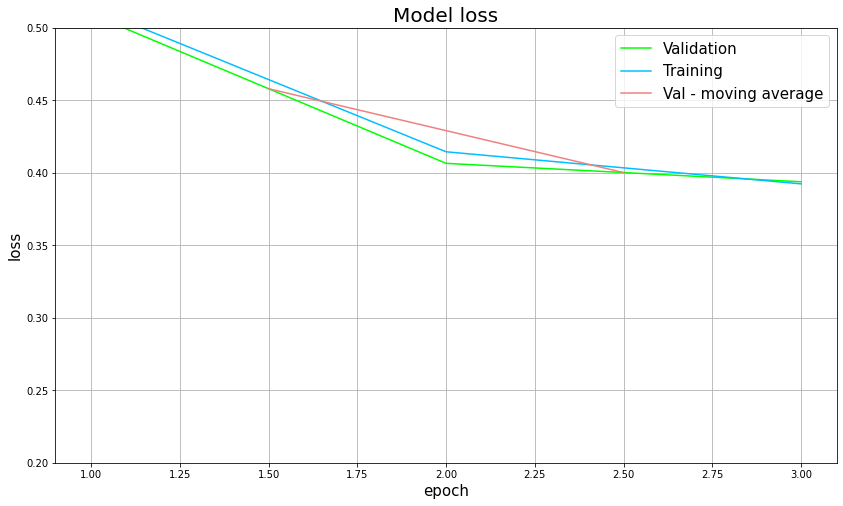

2021-05-03 15:19:46.608624


In [23]:
#Train and Validation loss vs epoch plot
print('Kernel size --> ',kernel_sizes[0])
w_width = 2
plt.figure(figsize=(14,8))

val_loss_offset = np.arange(1, len(history.history['val_loss']) + 1)
plt.plot(val_loss_offset, history.history['val_loss'], 'lime')
loss_offset = np.arange(1, len(history.history['loss']) + 1)
plt.plot(loss_offset, history.history['loss'], 'deepskyblue')

# Validation moving average
cumsum_vec = np.cumsum(np.insert(history.history['val_loss'], 0, 0)) 
ma_val = (cumsum_vec[w_width:] - cumsum_vec[:-w_width]) / w_width
ma_offset_X = np.arange(w_width/2+0.5, len(ma_val) + w_width/2+0.5)
plt.plot(ma_offset_X, ma_val, color='lightcoral')

# # Training moving average
# cumsum_vec = np.cumsum(np.insert(history.history['loss'], 0, 0)) 
# ma_train = (cumsum_vec[w_width:] - cumsum_vec[:-w_width]) / w_width
# ma_offset_X = np.arange(w_width/2+0.5, len(ma_train) + w_width/2+0.5)
# plt.plot(ma_offset_X, ma_train, 'red')


plt.title('Model loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['Validation', 'Training', 'Val - moving average'], loc='upper right', prop={'size': 15})
plt.grid(True)

plt.ylim(0.2, 0.5)
# plt.xlim(0,420)
plt.show()
print(datetime.now())

### Model Results

#### Final scores bar chart, th-plot and confusion matrix

In [ ]:
start_time = time.time()

# The code within the first set of hashtagged lines should be uncommented if no recent model has been run, 
# where you want a model from some weight files (stored via the "ModelCheckpoint" callback). 
# This may be useful when only the weights was stored from some model run, but the model
# crashed or you didn't have enough time to check the score results.

# The code within the second set of hashtagged lines should be uncommented if you want to compute the 
# best class-rounding threshold values and have them plotted

###############################################################################################################_________uncomment_start_1
# kernel_sizes = [4]
# b_size = 256
# epochs = 60
# steps_p_epoch = 200
# us_percent = 1.0
# ds_percent = 2.0
# dropout = 0.1
# learning_rate = 0.001

# val_split = 0.2
# filters = [16,32,64,128,256]
# pool_windows = [4,3,2]
# strides = 2
# fold_nr = 'N/A'

# #Downsampling
# X_train, y_train, other, ss_c, kc_c, both_c = resampler(X_Train, y_Train, us_percent, ds_percent)

# #Reshaping data to correct input format for neural network
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_Test.reshape(X_Test.shape[0], X_Test.shape[1], 1)

# #Printing header info
# print_header(fold_nr, pool_windows, strides, us_percent, ds_percent, X_train, X_test, other, ss_c, kc_c, both_c, filters, kernel_sizes[0], val_split, b_size)

# n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# model = get_model(n_timesteps, n_features, n_outputs, pool_windows, strides, filters, kernel_sizes[0], dropout, learning_rate) 

###############################################################################################################_________uncomment_stop_1


epoch_list = ['01',
              '02',
              '03']

best_f1 = []

for e in epoch_list:

  print('_______________________________________________________________________________________________________')
  print('\n Model results for epoch ----------------------->  ' + e + '\n\n')
  model_filepath = '/content/drive/My Drive/FYP BACK-UP/best_weights/FINAL_TEST_epoch=' + e + '.hdf5'
  # X_test = X_Test.reshape(X_Test.shape[0], X_Test.shape[1], 1) #Uncomment if loading weights without any model runn
  # model = load_model(model_filepath)                           #Uncomment if storing a model, and not weights
  model.load_weights(model_filepath)
  y_pred = model.predict(X_test)

  ###############################################################################################################_________uncomment_start_2
  # #Automatic class threshold finding
  # ss_dict = {}
  # kc_dict = {}

  # #-----------------------------------------
  # c_pred_ss = []
  # c_act_ss = []
  # f1_score_ss = []
  # pre_score_ss = []
  # re_score_ss = []
  # count_act_ss = sum((y_Test == (0., 1., 0.)).all(axis=1))
  # # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  # c_pred_kc = []
  # c_act_kc = []
  # f1_score_kc = []
  # pre_score_kc = []
  # re_score_kc = []
  # count_act_kc = sum((y_Test == (0., 0., 1.)).all(axis=1))
  # #-----------------------------------------

  # thresholds = np.arange(0.1, 0.9, 0.01)
  # for th in thresholds:
  #   th = round(th,2)
  #   # print('Calculating for th ----> ', th)

  #   ths = np.array([th,th])
  #   y_pred_r = th_rounder(copy.deepcopy(y_pred), ths)

  #   count_pred_ss = sum((y_pred_r == (0., 1., 0.)).all(axis=1)) 
  #   c_pred_ss.append(count_pred_ss)                                 
  #   c_act_ss.append(count_act_ss)

  #   count_pred_kc = sum((y_pred_r == (0., 0., 1.)).all(axis=1)) 
  #   c_pred_kc.append(count_pred_kc)
  #   c_act_kc.append(count_act_kc)

  #   f1_arr = f1_score(y_Test, y_pred_r, average=None, zero_division=1)[1:]
  #   pre_arr = precision_score(y_Test, y_pred_r, average=None, zero_division=1)[1:] #[0.45, 0.27]
  #   re_arr = recall_score(y_Test, y_pred_r, average=None, zero_division=1)[1:]
                                   
  #   f1_score_ss.append(f1_arr[0])
  #   pre_score_ss.append(pre_arr[0])
  #   re_score_ss.append(re_arr[0])

  #   f1_score_kc.append(f1_arr[1])
  #   pre_score_kc.append(pre_arr[1])
  #   re_score_kc.append(re_arr[1])

  #   ss_diff = abs(pre_arr[0] - re_arr[0])
  #   kc_diff = abs(pre_arr[1] - re_arr[1])
  #   ss_dict[th] = ss_diff
  #   kc_dict[th] = kc_diff

  #   # print('th--> ', round(th,3), '   Pre SS--> ',round(pre_arr[0],3), '   Re SS--> ',round(re_arr[0],3),'   SS diff--> ',round(ss_diff,3),
  #   #        '        Pre KC--> ',round(pre_arr[1],3), '   Re KC--> ',round(re_arr[1],3),'   KC diff--> ',round(kc_diff,3))

  # #-----------------------------------------
  # printThresholdPlot(c_pred_ss, c_act_ss, f1_score_ss, pre_score_ss, re_score_ss, thresholds, 'Sleep Spindle')
  # printThresholdPlot(c_pred_kc, c_act_kc, f1_score_kc, pre_score_kc, re_score_kc, thresholds, 'K-Complex')
  # #-----------------------------------------

  # auc_score_ss = auc(re_score_ss, pre_score_ss)
  # auc_score_kc = auc(re_score_kc, pre_score_kc)
  # print('Sleep Spindle PR AUC -->', auc_score_ss)
  # print('K-Complex PR AUC -->', auc_score_kc)

  
  # best_th_ss = min(ss_dict, key=ss_dict.get)
  # best_th_kc = min(kc_dict, key=kc_dict.get)
  # print('Best SS threshold --> ', best_th_ss)
  # print('Best KC threshold --> ', best_th_kc)

  # best_ths = [best_th_ss, best_th_kc]
  ###############################################################################################################_________uncomment_stop_2

  best_ths = [0.493, 0.439]
  y_pred_r = th_rounder(copy.deepcopy(y_pred), best_ths)

  # Prinntinng PR-curve & ROC-curve
  printCurve(y_Test, y_pred, 'Recall', 'Precision', 'Precision vs Recall Plot')
  printPR_AUC(y_Test, y_pred_r)
  printCurve(y_Test, y_pred, 'False Positive Rate', 'True Positive Rate', 'ROC curve')

  #Print confusion Matrix
  printConfusionMatrix(copy.deepcopy(y_Test), copy.deepcopy(y_pred_r))

  #Print final scores - F1, Precision, Recall
  printFinalScores(y_Test, y_pred_r)

  avg_f1 = f1_score(y_Test, y_pred_r, average='macro')
  print(np.round(avg_f1,3))
  best_f1.append(avg_f1)

print(model_filepath)
print('Best f1-score --> ', np.round(max(best_f1),3))
print(datetime.now())
print("\n------------ %s minutes -----------" % np.round((time.time() - start_time)/60,3))

#### Prediction counts

In [26]:
print('Predicted:') 
getCount(y_pred_r)
print('\nActuals:')
getCount(y_Test)

Predicted:
Other count:  111190
SS count:  0
KC count:  1443
Both count:  0
No classes:  0
Other and SS:  0
Other and KC:  0
All classes:  0

Actuals:
Other count:  104488
SS count:  3913
KC count:  3695
Both count:  537
No classes:  0
Other and SS:  0
Other and KC:  0
All classes:  0
